# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Step 00:  Do all imports and then print out summary

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.contrib.layers import flatten

import cv2

!conda list python
!conda list jupyter
!conda list numpy
!conda list tensorflow
!conda list matplotlib
!conda list scikit-learn
!conda list pandas
print(f"opencv version:           {cv2.__version__}")

# packages in environment at /home/macd/anaconda3:
#
ipython                   5.2.2                    py36_0  
ipython_genutils          0.1.0                    py36_0  
python                    3.6.0                         0  
python-dateutil           2.6.0                    py36_0  
# packages in environment at /home/macd/anaconda3:
#
jupyter                   1.0.0                    py36_0    conda-forge
jupyter_client            4.4.0                    py36_0  
jupyter_console           5.1.0                    py36_0  
jupyter_core              4.3.0                    py36_0  
# packages in environment at /home/macd/anaconda3:
#
numpy                     1.11.3                   py36_0  
numpydoc                  0.6.0                    py36_0  
# packages in environment at /home/macd/anaconda3:
#
tensorflow                1.0.0                    py36_0    conda-forge
tensorflow-gpu            1.0.0                     <pip>
# packages in environment at /home/macd/anac

---
## Step 0: Load The Data

In [2]:
# Load pickled data

training_file = "train.p"
validation_file = "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
#  The R stands for "Raw"
XR_train, y_train = train['features'], train['labels']
XR_valid, y_valid = valid['features'], valid['labels']
XR_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [3]:
XR_train.shape

(34799, 32, 32, 3)

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
#  Number of training examples
n_train = XR_train.shape[0]

# Number of validation examples
n_valid = XR_valid.shape[0]

# Number of testing examples.
n_test = XR_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = (XR_train.shape[1], XR_train.shape[2])

# How many unique classes/labels there are in the dataset.
signame = pd.read_csv('signnames.csv')
n_classes = signame.shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Number of different labels in each set

In [5]:
cnt_tr = []
cnt_va = []
cnt_ts = []
for cnt, y in zip((cnt_tr, cnt_va, cnt_ts), (y_train, y_valid, y_test)):
    ps_labels = pd.Series(y)
    for i in range(n_classes):
        cnt.append(ps_labels[ps_labels == i].count())
        
ar = np.column_stack((np.array(cnt_tr), np.array(cnt_va), np.array(cnt_ts)))
countDF = pd.DataFrame(ar, index=signame['SignName'], columns=['training', 'validation', 'test'])
countDF.head(43)     

,training,validation,test
SignName,,,
Speed limit (20km/h),180,30,60
Speed limit (30km/h),1980,240,720
Speed limit (50km/h),2010,240,750
Speed limit (60km/h),1260,150,450
Speed limit (70km/h),1770,210,660
Speed limit (80km/h),1650,210,630
End of speed limit (80km/h),360,60,150
Speed limit (100km/h),1290,150,450
Speed limit (120km/h),1260,150,450


Clearly, there are some big class imbalances here (on the order of 11 to 1).  In this small amount of data, we probably do not want to downsample the classes that have large frequencies.  One idea would be to generate more synthetic data (distortions, translations, etc) for the classes that have small counts, but I did not do that here.

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

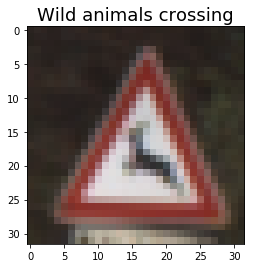

In [6]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# 500: Wild animals crossing
# 2113: Slippery road
# 15421: Keep right

def show_sample(ns):
    plt.imshow(XR_train[ns, :, :, :])
    plt.title(signame.ix[y_train[ns]][1], fontsize=18)
    
show_sample(500)

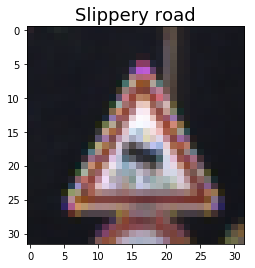

In [7]:
show_sample(2116)

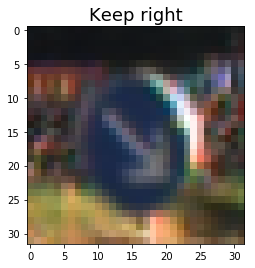

In [8]:
show_sample(15425)  # 15421

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Before preprocessing the data, we will first augment the images.  The data augmentations will be as outlined in the LeCunn paper with 5 transformed copies of the original image with the following transformations: jitter the position randomly in the range [-2, +2] pixels, in rescale the image randomly in the range [0.9, 1.1] and randomly rotate the image by [-15, +15] degrees

In [9]:
def jitter_image(img, dx, dy):
    '''
    This jitters the image placement by dx columns and dy rows, where
    dx and dy can both be negative or positive integers.  We maintain
    the initial shape of the image and we pad with a global average value
    '''
    nrows, ncols, nchans = img.shape
    if dx == dy == 0:
        return img
    delta_top = delta_bot = delta_left = delta_right = 0
    mc = img.ravel().mean()
    if dy >= 0:
        delta_top = dy
        r_start = 0
        r_end = nrows     
    else:
        dy = np.abs(dy)
        delta_bot = dy
        r_start = dy
        r_end = nrows + dy
        
    if dx >= 0:
        delta_right = dx
        c_start = dx
        c_end = ncols + dx
    else:
        delta_left = np.abs(dx)
        c_start = 0
        c_end = ncols

    pad = cv2.copyMakeBorder(img, delta_top, delta_bot, delta_left, delta_right, cv2.BORDER_CONSTANT, value=[mc,mc,mc])
    jit = pad[r_start:r_end, c_start:c_end, :]
    return jit


def rescale_image(img, scale):
    """
    HACK: We assume that the image is square and that both the image size 
    and the scale are both even or both odd so that (nrows - scale) is even
    
    Scale an image up or down depending on scale.  We still want to keep
    the same pixel size, so if we scale it down, we will pad out to original
    size with the global mean.  If we scale it up, we will cut out the center.
    
    NOTE: scale is _not_ a scale factor.  It is the new size of the square image,
    which is then resized back to the original either by padding or truncation
    """
    nrows, ncols, nchans = img.shape
    assert((nrows == ncols) and (nrows % 2 == scale % 2))
    if nrows == scale:
        return img
    
    rimg = cv2.resize(img, (scale, scale))
    mc = img.ravel().mean()
    delta = (nrows - scale) // 2
    if delta > 0:
        fimg = cv2.copyMakeBorder(rimg, delta, delta, delta, delta, cv2.BORDER_CONSTANT, value=[mc,mc,mc])
    else:
        # a little too clever perhaps... remember delta is negative
        fimg = rimg[-delta:delta, -delta:delta, :]
        
    return fimg


def rotate_image(img, deg):
    if deg == 0:
        return img
    nrows, ncols, nchans = img.shape
    M = cv2.getRotationMatrix2D((ncols//2, nrows//2), deg, 1)
    dst = cv2.warpAffine(img, M, (ncols, nrows))
    return dst


def rgb2bgr(img):
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    return(cv2.merge([b, g, r]))

def bgr2rgb(img):
    b, g, r = cv2.split(img)
    return(cv2.merge([r, g, b]))


def generate_augmented(X, y, n):
    nmeas, nrows, ncols, nchans = X.shape
    X_augmented = np.zeros(((n + 1) * nmeas, nrows, ncols, nchans))
    y_augmented = np.zeros((n + 1) * nmeas, dtype=np.int)
    for j in range(nmeas):
        nj = (n + 1) * j
        X_augmented[nj, :, :, :] = img = X[j, :, :, :]
        y_augmented[nj] = y[j]
        # flip image for opencv
        img = rgb2bgr(img)
        for i in range(1, n + 1):
            dx = np.random.randint(-2, 2)
            dy = np.random.randint(-2, 2)
            rescale = np.random.choice([28,30,32,34,36])
            rotate = np.random.uniform(-15., 15)
            jimg = jitter_image(img, dx, dy)
            rimg = rescale_image(jimg, rescale)
            rot_img = rotate_image(rimg, rotate)
            X_augmented[nj + i, :, :, :] = bgr2rgb(rot_img)
            y_augmented[nj + i] = y[j]
        
    return X_augmented, y_augmented


AUGMENT = True
n_augment = 5

if AUGMENT:
    XA_train, y_train = generate_augmented(XR_train, y_train, n_augment)
else:
    XA_train = XR_train

print(f'{XA_train.shape}   {y_train.shape}')

(208794, 32, 32, 3)   (208794,)


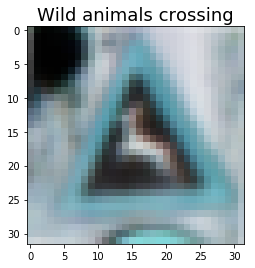

In [10]:
def show_sample(ns):
    plt.imshow(XA_train[ns, :, :, :])
    plt.title(signame.ix[y_train[ns]][1], fontsize=18)

show_sample(5000)

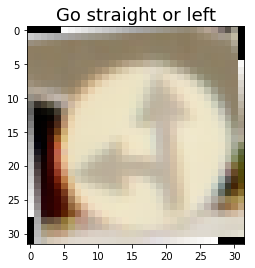

In [11]:
show_sample(30009)

### Data Preprocessing
Here we normalize the data

training global mean: 78.35995510278255
training global stddev: 63.30874621109871
mean test augmented data: 78.35995510278255
mean test normalized data: 6.655465707410719e-15
X_train shape: (208794, 32, 32, 1)
Wild animals crossing


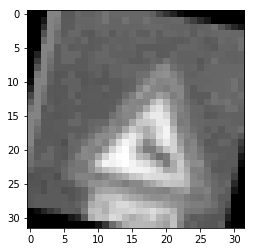

In [12]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# Do the grey scale conversion, if desired, before mean and stddev normalization
GREY_SCALE = True

def convert_images(x):
    nsmpls, nrows, ncols, nchans = x.shape
    xg = np.zeros((nsmpls, nrows, ncols, 1))
    for i in range(nsmpls):
        xg[i, :, :, 0] = 0.299*x[i, :, :, 0] + 0.587*x[i, :, :, 1] + 0.114*x[i, :, :, 2]
        
    return xg
    
# Must convert test and validation sets as well
if GREY_SCALE:
    XA_train = convert_images(XA_train)
    XR_test  = convert_images(XR_test)
    XR_valid = convert_images(XR_valid)
    
# global mean and std deviation.  I found using the global mean and stddev to be
# more effective than using a per-channel normalization
mean = XA_train.ravel().mean()
std = XA_train.ravel().std()

print(f"training global mean: {mean}")
print(f"training global stddev: {std}")

XN_train = (XA_train - mean) / std
XN_valid = (XR_valid - mean) / std
XN_test  = (XR_test - mean) / std
    
print(f"mean test augmented data: {XA_train[:, :, :, 0].ravel().mean()}")
print(f"mean test normalized data: {XN_train[:, :, :, 0].ravel().mean()}")
    
X_train = XN_train
X_valid = XN_valid
X_test = XN_test
print(f'X_train shape: {X_train.shape}')

# Plot an example of the grey scale rotated image
plt.imshow(X_train[2001, :, :, 0], cmap='gray')
print(signame.ix[y_train[2001]][1])

### Model Architecture

I find it easier to have all the weight and bias definitions in one place.  It is easier to check dimensionality that way. The following is a straightforward modification of LeNet to accomodate the different number of classes. It is set up to use the full color images, but can be changed to use greyscale by changing the dimensions of the 'wc1' layer to [5, 5, 1, 6]

In [13]:
mu = 0
sigma = 0.1

weights = {'wc1': tf.Variable(tf.truncated_normal([5, 5, 3, 6],  mean=mu, stddev=sigma)),
           'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
           'wf3': tf.Variable(tf.truncated_normal([400, 120],    mean=mu, stddev=sigma)),
           'wf4': tf.Variable(tf.truncated_normal([120, 84],     mean=mu, stddev=sigma)),
           'wf5': tf.Variable(tf.truncated_normal([84, 43],      mean=mu, stddev=sigma)) 
          }

biases = { 'bc1': tf.Variable(tf.zeros([6])),
           'bc2': tf.Variable(tf.zeros([16])),
           'bf3': tf.Variable(tf.zeros([120])),
           'bf4': tf.Variable(tf.zeros([84])),
           'bf5': tf.Variable(tf.zeros([43]))
         }


def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


def LeNet(x):    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    # this also add the activation
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])    
    print("conv1 shape: ", conv1.get_shape())
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = maxpool2d(conv1)
    print("pool1 shape: ", pool1.get_shape())
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(pool1, weights['wc2'], biases['bc2'])
    print("conv2 shape: ", conv2.get_shape())
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = maxpool2d(conv2)
    print("poll2 shape: ", pool2.get_shape())
    
    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(pool2)
    #flat = tf.reshape(pool2, [-1, weights['wf3'].get_shape().as_list()[0]])
    print("flat: ", flat.get_shape())
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    full3 = tf.add(tf.matmul(flat, weights['wf3']), biases['bf3'])
    print("full3 shape: ", full3.get_shape())
    
    # Activation.
    full3 = tf.nn.relu(full3)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    full4 = tf.add(tf.matmul(full3, weights['wf4']), biases['bf4'])
    print("full4 shape: ", full4.get_shape())
    
    # Activation.
    full4 = tf.nn.relu(full4)
    
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(full4, weights['wf5']), biases['bf5'])    
    print("logits shape: ", logits.get_shape())
    return logits

This is a modification of LeNet to include some of the multi-scale structure mentioned in the paper. It is not exactly the same as that net however.  Also, this is set up to receive grey scale images.

In [14]:
ms_weights = {'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 6],  mean=mu, stddev=sigma)), # [5,5,3,6] for rgb
              'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
              'wf3': tf.Variable(tf.truncated_normal([1576, 120],   mean=mu, stddev=sigma)),
              'wf4': tf.Variable(tf.truncated_normal([120, 84],     mean=mu, stddev=sigma)),
              'wf5': tf.Variable(tf.truncated_normal([84, 43],      mean=mu, stddev=sigma)) 
             }

ms_biases = { 'bc1': tf.Variable(tf.zeros([6])),
              'bc2': tf.Variable(tf.zeros([16])),
              'bf3': tf.Variable(tf.zeros([120])),
              'bf4': tf.Variable(tf.zeros([84])),
              'bf5': tf.Variable(tf.zeros([43]))
            }


def multi_scale(x):    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    # this also add the activation
    conv1 = conv2d(x, ms_weights['wc1'], ms_biases['bc1'])    
    print("conv1 shape: ", conv1.get_shape())
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = maxpool2d(conv1)
    print("pool1 shape: ", pool1.get_shape())
    
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(pool1, ms_weights['wc2'], ms_biases['bc2'])
    print("conv2 shape: ", conv2.get_shape())
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = maxpool2d(conv2)
    print("poll2 shape: ", pool2.get_shape())
    
    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(pool2)
    #flat = tf.reshape(pool2, [-1, weights['wf3'].get_shape().as_list()[0]])
    print(f"flat:   {flat.get_shape()}  {flat.dtype}")
    
    #  output = 1176
    skip_flat = flatten(pool1)
    print(f"skip_flat: {skip_flat.get_shape()}  {skip_flat.dtype}")
    
    # mlevel will be 1576
    mlevel = tf.concat((flat, skip_flat), 1)
    print(f"mlevel: {mlevel.get_shape()}")
    
    # Layer 3: Fully Connected. Input = 1576. Output = 120.
    full3 = tf.add(tf.matmul(mlevel, ms_weights['wf3']), ms_biases['bf3'])
    print("full3 shape: ", full3.get_shape())
    
    # Activation.
    full3 = tf.nn.relu(full3)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    full4 = tf.add(tf.matmul(full3, ms_weights['wf4']), ms_biases['bf4'])
    print("full4 shape: ", full4.get_shape())
    
    # Activation.
    full4 = tf.nn.relu(full4)
    
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(full4, ms_weights['wf5']), ms_biases['bf5'])    
    print("logits shape: ", logits.get_shape())
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [15]:
if GREY_SCALE:
    x = tf.placeholder(tf.float32, (None, 32, 32, 1))
else:
    x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Loss and Optimizer Setup

In [16]:
rate = 0.001

#logits = LeNet(x)
logits = multi_scale(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

conv1 shape:  (?, 28, 28, 6)
pool1 shape:  (?, 14, 14, 6)
conv2 shape:  (?, 10, 10, 16)
poll2 shape:  (?, 5, 5, 16)
flat:   (?, 400)  <dtype: 'float32'>
skip_flat: (?, 1176)  <dtype: 'float32'>
mlevel: (?, 1576)
full3 shape:  (?, 120)
full4 shape:  (?, 84)
logits shape:  (?, 43)


### Model Evaluation

In [17]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Setup training loop and do the training

In [18]:
EPOCHS = 100
BATCH_SIZE = 128   # 512

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.910

EPOCH 2 ...
Validation Accuracy = 0.940

EPOCH 3 ...
Validation Accuracy = 0.938

EPOCH 4 ...
Validation Accuracy = 0.941

EPOCH 5 ...
Validation Accuracy = 0.947

EPOCH 6 ...
Validation Accuracy = 0.949

EPOCH 7 ...
Validation Accuracy = 0.953

EPOCH 8 ...
Validation Accuracy = 0.946

EPOCH 9 ...
Validation Accuracy = 0.944

EPOCH 10 ...
Validation Accuracy = 0.952

EPOCH 11 ...
Validation Accuracy = 0.963

EPOCH 12 ...
Validation Accuracy = 0.946

EPOCH 13 ...
Validation Accuracy = 0.929

EPOCH 14 ...
Validation Accuracy = 0.957

EPOCH 15 ...
Validation Accuracy = 0.955

EPOCH 16 ...
Validation Accuracy = 0.963

EPOCH 17 ...
Validation Accuracy = 0.953

EPOCH 18 ...
Validation Accuracy = 0.948

EPOCH 19 ...
Validation Accuracy = 0.954

EPOCH 20 ...
Validation Accuracy = 0.950

EPOCH 21 ...
Validation Accuracy = 0.945

EPOCH 22 ...
Validation Accuracy = 0.949

EPOCH 23 ...
Validation Accuracy = 0.945

EPOCH 24 ...
Validation Accura

### Check Model on Test Set

In [19]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.949


## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

The file names reflect what I though at the time I downloaded them.  Later, I found a site that gave the correct sign purpose and this is discussed later.

In [20]:
signs = ['attention.jpg', 'bicycle.jpg',  'no_entry.jpg',  'workers.jpg',
         'noidea.jpg',   'highway.jpg',  'parking.jpg']

cv2_signs = []
for sg in signs:
    cv2_signs.append(cv2.imread(sg))
    print(f'image: {sg}  shape: {cv2_signs[-1].shape}')

image: attention.jpg  shape: (185, 273, 3)
image: bicycle.jpg  shape: (214, 235, 3)
image: no_entry.jpg  shape: (252, 200, 3)
image: workers.jpg  shape: (180, 240, 3)
image: noidea.jpg  shape: (194, 259, 3)
image: highway.jpg  shape: (229, 220, 3)
image: parking.jpg  shape: (157, 320, 3)


opencv uses a B, G, R ordering of the color channels, while matplotlib expects R, G, B.  Since we want to show in the notebook, we must use matplotlib's version of imshow. That means we have to covert the channel ordering before plotting.

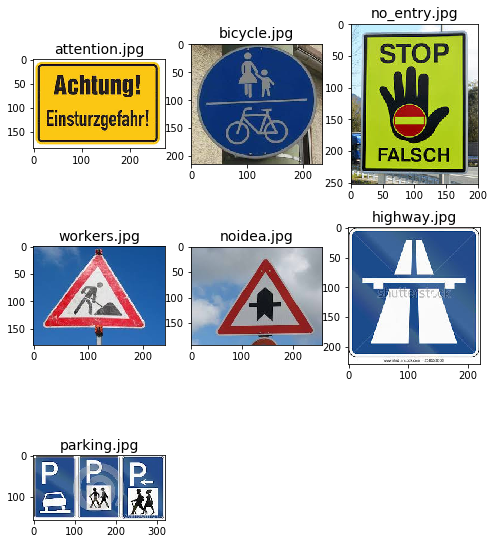

In [21]:
def rgb_convert(cv2_list):
    '''Convert list of opencv BGR to list of RGB images'''
    rgb_list = []
    for img in cv2_list:
        b, g, r = cv2.split(img)          # get b,g,r
        rgb_img = cv2.merge([r, g, b])    # switch it to rgb
        rgb_list.append(rgb_img)
    return rgb_list


def show_cv2(img):
    '''Show a single cv2 image in a Jupyter notebook'''
    b, g, r = cv2.split(img)          # get b,g,r
    rgb_img = cv2.merge([r, g, b])    # switch it to rgb
    plt.imshow(rgb_img)
    
    
def show_rgb_images(images, titles, figsize=(8, 10), fontsize=14):
    '''Quick hack... assumes a 3 x 3 grid of images'''
    fig = plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        a = fig.add_subplot(3, 3, i+1)
        a.imshow(img)        
        a.set_title(titles[i], fontsize=fontsize)
        
rgb_signs = rgb_convert(cv2_signs)
    
show_rgb_images(rgb_signs, signs)

Now we want to convert into images that can be fed into LeNet. We first pad out the images to make them square and then resize them to 32 x 32

In [22]:
def make_square(x):
    h, w, c = x.shape
    if h == w:
        return x
    elif h < w:
        # pad vertically
        delta_top = (w - h) // 2
        delta_bot = delta_top + 1 if (w - h) % 2 else delta_top
        delta_left = 0
        delta_right = 0
    else:
        delta_top = 0
        delta_bot = 0
        delta_left = (h - w) // 2
        delta_right = delta_left + 1 if (h - w) % 2 else delta_left
        
    sqr = cv2.copyMakeBorder(x, delta_top, delta_bot, delta_left, delta_right, cv2.BORDER_REPLICATE)
    return sqr

In [23]:
munged_images = []
for cv2_image in cv2_signs:
    sqr = make_square(cv2_image)
    munged_images.append(cv2.resize(sqr, (32, 32), interpolation=cv2.INTER_AREA))

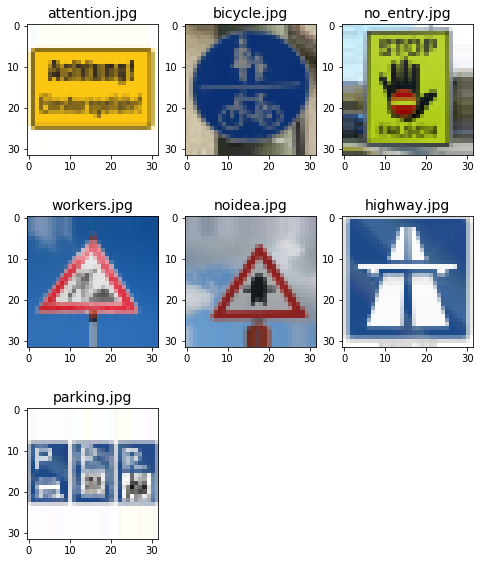

In [24]:
# convert cv2's BGR to matplotlib's RGB
rgb_munged_images = rgb_convert(munged_images)
show_rgb_images(rgb_munged_images, signs)

### Predict the Sign Type for Each Image

No entry
Go straight or right
Stop
Road work
Right-of-way at the next intersection
Traffic signals
Speed limit (20km/h)


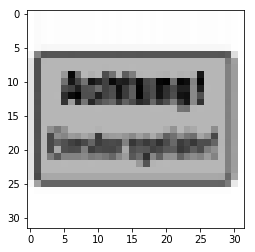

In [25]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

nrgb_images = []
for img in rgb_munged_images:
    rgb = np.array(img, dtype=np.float32)
    rgb = (rgb - mean) / std
    nrgb_images.append(rgb)
    
if GREY_SCALE:
    grey_images = []
    for img in rgb_munged_images:
        gimg = np.zeros((32, 32, 1))
        gimg[:, :, 0] = 0.299*img[:, :, 0] + 0.587*img[:, :, 1] + 0.114*img[:, :, 2]
        gimg = (gimg - mean) / std
        grey_images.append(gimg)
        
    feed_images = grey_images
else:
    feed_images = nrgb_images
    
plt.imshow(feed_images[0][:, :, 0], cmap='gray')
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pcls = sess.run(tf.nn.softmax(logits), feed_dict={x: feed_images})

predictions = []
for pick in pcls:
    ns = pick.argmax()
    pred = signame.ix[ns][1]
    predictions.append(pred)
    print(pred)
    

Finally we show the rgb 32x32 images with the labels predicted by the trained net.

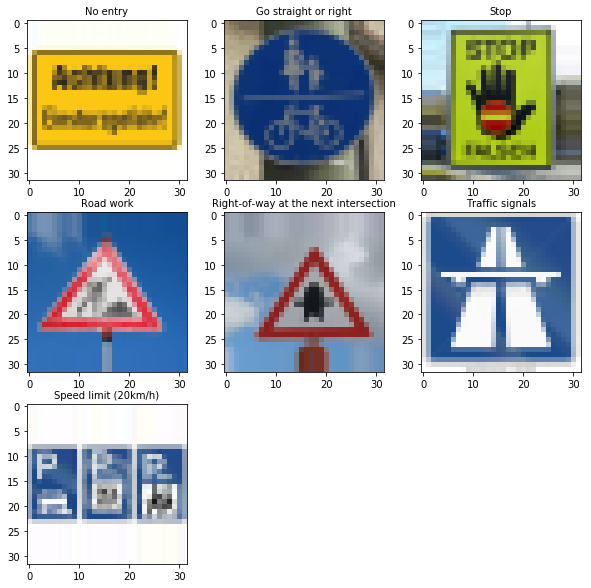

In [26]:
show_rgb_images(rgb_munged_images, predictions, figsize=(10, 10), fontsize=10)

### Analyze Performance

Here is a summary of the predicted sign vs. the correct one and if the correct sign was in the training set.  I found a good resource for German traffic signs [here](http://www.gettingaroundgermany.info/zeichen.shtml)

image number | predicted sign | correct sign |  Correctly predicted? | In training set ? 
:-------------:|:--------------:|:------------:|:------:|:---------------:
      1      | No entry  | Danger Risk of Collapse |    No | No
      2      | Go straight or right     | Pedistrian and bicycle path |  No  | No
      3      | Stop | Stop  | Yes | Yes 
      4      | Road Work       |  Road Work | Yes | Yes   
      5      | Right of way... | Right of way... | Yes | Yes
      6      | Traffic signals | Autobahn Entrance | No | No
      7      | Speed limit (20km/h)    | Parking on sidewalk... | No |No
      
**Final accuracy is 3 out of 7 or 42.8%**

We can see that most of the errors are due to the signs being absent from the training data.  However, sign 3 is an interesting case.  In the center of the sign, there is clearly the no entry symbol.  However, that is embedded in a big hand with the words "Stop" and "Incorrect" around it.  Too much clutter for the NN to correctly predict the sign, it seems.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [27]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pcls = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k = 5), feed_dict={x: feed_images})

print(pcls)

TopKV2(values=array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  9.99997258e-01,   2.74960553e-06,   2.47461829e-09,
          8.67356063e-15,   5.74361818e-16],
       [  9.99999881e-01,   8.59512497e-08,   8.48747376e-23,
          6.59615830e-27,   5.91022056e-31],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.73091257e-15,   1.57232755e-29,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[17,  0,  1,  2,  3],
       [36, 23, 40, 28, 11],
       [14, 40, 38,  2,  3],
       [25,  0,  1,  2,  3],
       [11,  0,  1,  2,  3],
       [26,  0,  1,  2,  3],
       [ 0,  1, 25,  2,  3]], dtype=in

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 